# Plume Analysis

In [1]:
%matplotlib inline
%reset -f
import fnmatch
import scipy.optimize as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob
from IPython.display import set_matplotlib_formats
from scipy.optimize import curve_fit
import re
import datetime as dt 
import scipy.signal

%config InlineBackend.figure_formats = ['svg']
plt.rcParams['savefig.dpi'] = 350
plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 1.

In [2]:
def plume_analysis(df):
    data_T=df['temperature'].values; data_U=df['velocity:0'].values
    data_Y=df['Points:1'].values; data_Z=df['Points:2'].values #not hieght

    # this will depend on model resolution !!
    y_nodes_num=257; z_nodes_num=257
    T_blocks=np.zeros( (256,256) ); U_blocks=np.zeros( (256,256) )

    for i in range(y_nodes_num-1):
        for j in range(z_nodes_num-1):
            gnv=y_nodes_num*j+i # global node value
            T_blocks[i,j]=0.25*(data_T[gnv]+data_T[gnv+1]+data_T[gnv+y_nodes_num]+data_T[gnv+y_nodes_num+1])
            U_blocks[i,j]=0.25*(data_U[gnv]+data_U[gnv+1]+data_U[gnv+y_nodes_num]+data_U[gnv+y_nodes_num+1])

    max_temp=np.max(T_blocks); avg_temp=np.mean(T_blocks); thd_temp=avg_temp+0.2*(max_temp-avg_temp)

    P_blocks=np.zeros( (256,256) )

    da=(data_Y[1]-data_Y[0])**2 #area

    pmf=0; phf=0; plume_temp=0; plume_cells=0; 

    for i in range(y_nodes_num-1):
        for j in range(z_nodes_num-1):
            if (T_blocks[i,j]>=thd_temp) and (U_blocks[i,j]>0):
                plume_cells+=1
                plume_temp+=T_blocks[i,j]
                P_blocks[i,j]=1
                pmf+=U_blocks[i,j]*da
                phf+=U_blocks[i,j]*(T_blocks[i,j]-avg_temp)*da

    plume_temp=plume_temp/plume_cells
    dT = plume_temp-avg_temp
    return phf, dT

In [55]:
ra_path = '1e8'; plume_path = '\\Plume Data'
main_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions\\'

fname = os.path.join(main_path+ra_path+plume_path,'[!m]*.csv')
fileL = glob.glob(fname) #list of files
temp = []
for file in fileL:
    a = fileL.index(file)
    b = pd.read_csv(file)
    b.rename(columns={0:a}, inplace=True)
    temp.append(b)

Data = pd.concat(temp, axis=0, join="inner",ignore_index=True)

lenZ = len(fileL)

zUnique = Data['Points:0'].unique()

data = [[] for i in range(lenZ)] #empty nested list

for i in range(lenZ):
    data[i] = Data.loc[Data['Points:0'] == zUnique[i]]
    data[i] = data[i].reset_index(drop=True)
    
plumeData = pd.DataFrame(columns=['Ra', 'Z', 'Q_p', 'dT_p'],
                  index=range(0, lenZ))

plumeData['Ra'] = int(float(ra_path))

for i in range(lenZ):
    pa = plume_analysis(data[i])
    plumeData.at[i, 'Z'] = zUnique[i]
    plumeData.at[i, 'Q_p'] = pa[0]
    plumeData.at[i, 'dT_p'] = pa[1]

plumeData = plumeData.sort_values(by=['Z'])
plumeData = plumeData.reset_index(drop=True) 
plumeData

,Ra,Z,Q_p,dT_p
0,100000000,0.01,45.801577,0.211018
1,100000000,0.02,51.875332,0.249195
2,100000000,0.03,49.520909,0.240792
3,100000000,0.04,48.522906,0.23278
4,100000000,0.05,48.678349,0.223619
...,...,...,...,...
94,100000000,0.95,17.307075,0.129841
95,100000000,0.96,17.695587,0.121859
96,100000000,0.97,16.944697,0.125116
97,100000000,0.98,16.103322,0.112793


In [56]:
save_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Data\\'
Data=pd.read_csv(save_path+'data_short.csv')
data_select = Data.loc[Data['Ra']==plumeData.at[0, 'Ra']]
data_select = data_select.reset_index(drop=True)
nut = data_select.at[0, 'NuT']

Text(0.5, 0, 'Plume Heat Flux')

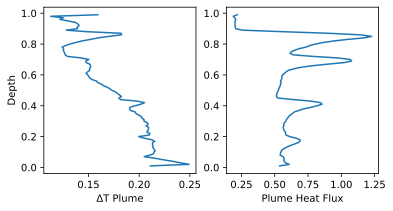

In [57]:
plt.figure(figsize=(6,3))

plt.subplot(1, 2, 1)
plt.plot(plumeData['dT_p'],plumeData['Z'])
plt.xlabel(u'ΔT Plume')
plt.ylabel('Depth')

plt.subplot(1, 2, 2)
plt.plot(plumeData['Q_p']/nut,plumeData['Z'])
plt.xlabel('Plume Heat Flux')

In [58]:
(plumeData.loc[(plumeData['Z'] > 0.499) & (plumeData['Z'] < 1),'Q_p']/nut).mean()

0.6274532687259221

In [59]:
np.savetxt(main_path+ra_path+'\\Plume Profiles\\Depth.txt',plumeData['Z'])
np.savetxt(main_path+ra_path+'\\Plume Profiles\\Delta_T_Plume.txt',plumeData['dT_p'])
np.savetxt(main_path+ra_path+'\\Plume Profiles\\Plume_Heat_Flux.txt',plumeData['Q_p']/nut)

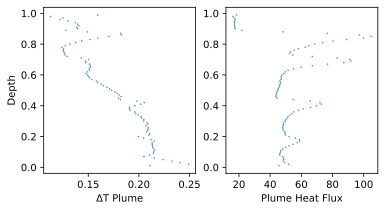

In [60]:
plt.figure(figsize=(6,3))

plt.subplot(1, 2, 1)
plt.plot(plumeData['dT_p'],plumeData['Z'],'.')
plt.xlabel(u'ΔT Plume')
plt.ylabel('Depth')

plt.subplot(1, 2, 2)
plt.plot(plumeData['Q_p'],plumeData['Z'],'.')
plt.xlabel('Plume Heat Flux');